# Audio Classification: CNN Baseline Model

**Course:** CSCI 6366 (Neural Networks and Deep Learning)  
**Project:** Audio Classification using CNN  
**Notebook:** Baseline CNN Model Implementation

## What this notebook will do? (Plan)

By the end of this new notebook, we want to have (ideally):

1. A **fixed-size input representation** for each audio clip:
   → Mel-spectrogram shaped like `(128, 128, 1)` (height × width × channels).

2. A **small CNN model** defined in Keras:

   ```python
   Conv2D → ReLU → MaxPooling2D → Conv2D → MaxPooling2D → Flatten → Dense → Softmax
   ```

3. The model **compiled** with:
   * `loss='categorical_crossentropy'`
   * `optimizer='adam'`
   * `metrics=['accuracy']`

We'll focus on:
* shaping the data,
* building the model,
* understanding every layer.

(We won't worry about perfect training yet in this notebook)


In [4]:
import numpy as np
from pathlib import Path

import librosa

import tensorflow as tf
from tensorflow.keras import layers, models


### Imports

* `numpy` → arrays and math.
* `Path` → nice file paths.
* `librosa` → we'll reuse it to build Mel-spectrograms.
* `tensorflow` / `keras`:
  * `layers` → Conv2D, MaxPooling2D, Flatten, Dense, etc.
  * `models` → to create the `Sequential` model.

If you (the person trying to run this notebook on his/her machine) get an error on TensorFlow, install it in your venv:

```bash
(.venv) pip install "tensorflow>=2.16,<3"
```

(run in the terminal, not in the notebook).


In [5]:
# Where our audio data lives (relative to this notebook in notebooks/)
DATA_DIR = Path("../data").resolve()

# Our three classes
CLASS_NAMES = ["dog", "cat", "bird"]

label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}
label_to_index


{'dog': 0, 'cat': 1, 'bird': 2}

### Basic Config and Class Labels

* `DATA_DIR` points to your `data/` folder from this notebook (`../data`).
* `CLASS_NAMES` is the list of class labels (folder names under `data/`).
* `label_to_index` turns labels into numbers:
  * `"dog" → 0`, `"cat" → 1`, `"bird" → 2`.
* This mapping will be used for training targets.



In [6]:
def load_mel_spectrogram(
    audio_path: Path,
    sr: int = 16000,
    n_fft: int = 1024,
    hop_length: int = 512,
    n_mels: int = 128,
) -> tuple[np.ndarray, int]:
    """
    Load an audio file and compute its Mel-spectrogram in dB scale.

    Returns:
        S_db: 2D array of shape (n_mels, time_frames), Mel-spectrogram in dB.
        sr: sample rate used.
    """
    # 1. Load waveform, resampled to `sr` if needed
    y, sr = librosa.load(audio_path, sr=sr)

    # 2. Compute Mel-spectrogram (power)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )

    # 3. Convert to dB scale
    S_db = librosa.power_to_db(S, ref=np.max)

    return S_db, sr


### load_mel_spectrogram Function

* **Input**: path to `.wav` file.
* **Inside**:
  * Load waveform `y` at `sr` (16k).
  * Compute Mel-spectrogram `(n_mels × time_frames)`.
  * Convert to dB (log scale).
* **Output**: `S_db` (2D spectrogram), `sr`.

This function is **our bridge** from "raw audio file" → "2D array we'll feed into the CNN".


In [7]:
def pad_or_crop_spectrogram(S_db: np.ndarray, target_shape=(128, 128)) -> np.ndarray:
    """
    Ensure the Mel-spectrogram has shape (target_height, target_width)
    by centrally cropping or zero-padding along the time axis.

    Assumes S_db shape is (n_mels, time_frames).
    """
    target_height, target_width = target_shape
    n_mels, time_frames = S_db.shape

    # 1. If mel dimension doesn't match target_height, we could pad/crop,
    #    but here we assume n_mels == target_height (128).
    if n_mels != target_height:
        raise ValueError(f"Expected {target_height} mel bands, got {n_mels}")

    # 2. If too many time frames: centrally crop to target_width
    if time_frames > target_width:
        start = (time_frames - target_width) // 2
        end = start + target_width
        S_db = S_db[:, start:end]

    # 3. If too few time frames: pad with zeros on the right
    elif time_frames < target_width:
        pad_width = target_width - time_frames
        S_db = np.pad(
            S_db,
            pad_width=((0, 0), (0, pad_width)),  # only pad time axis on the right
            mode="constant",
            constant_values=(S_db.min(),),
        )

    # Now S_db has shape (target_height, target_width)
    return S_db


### Making the Spectrogram a Fixed Size (128×128)

Right now different clips might have different `time_frames` (widths), depending on duration.

CNNs want **fixed shape** input. So we'll:
* Keep height = `n_mels = 128`.
* Force width = `128` by:
  * **If too long** → cut the center to 128 columns.
  * **If too short** → pad with zeros on the right.

### Explanation

* `S_db.shape` gives `(n_mels, time_frames)`.
* We **expect** `n_mels = 128`, and want `time_frames = 128`.
* If `time_frames > 128`:
  * We compute a `start` index so we crop the **center** portion.
* If `time_frames < 128`:
  * We pad columns on the right with the **minimum** value (darkest color).

Result: every clip becomes a **128×128 matrix**.


In [8]:
def load_example_for_model(audio_path: Path, label: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Load one audio file and return:
      X: Mel-spectrogram as float32 array with shape (128, 128, 1)
      y: one-hot encoded label array with shape (num_classes,)
    """
    # 1. Mel-spectrogram in dB
    S_db, sr = load_mel_spectrogram(audio_path)

    # 2. Ensure fixed size 128x128
    S_fixed = pad_or_crop_spectrogram(S_db, target_shape=(128, 128))

    # 3. Normalize (optional but common): scale to [0, 1]
    #    We shift and scale based on min and max of this spectrogram
    S_min = S_fixed.min()
    S_max = S_fixed.max()
    S_norm = (S_fixed - S_min) / (S_max - S_min + 1e-8)  # avoid divide-by-zero

    # 4. Add channel dimension → (128, 128, 1)
    X = S_norm.astype("float32")[..., np.newaxis]

    # 5. Build one-hot label vector
    num_classes = len(CLASS_NAMES)
    y = np.zeros(num_classes, dtype="float32")
    y[label_to_index[label]] = 1.0

    return X, y


### Convert Audio File: Model-Ready Input & Label

We make a function that:
* Takes:
  * `audio_path`
  * `label` (e.g., `"dog"`)
* Returns:
  * `X`: spectrogram with shape `(128, 128, 1)` (extra channel dimension).
  * `y`: one-hot label like `[1, 0, 0]` for dog.

### Explanation

1. **Get Mel-spectrogram**:
   ```python
   S_db, sr = load_mel_spectrogram(audio_path)
   ```

2. **Make it 128×128**:
   ```python
   S_fixed = pad_or_crop_spectrogram(S_db, target_shape=(128, 128))
   ```

3. **Normalize**:
   ```python
   S_min = S_fixed.min()
   S_max = S_fixed.max()
   S_norm = (S_fixed - S_min) / (S_max - S_min + 1e-8)
   ```
   * This maps values to roughly `[0, 1]`.
   * Normalization helps training.

4. **Add channel dimension**:
   ```python
   X = S_norm.astype("float32")[..., np.newaxis]
   ```
   * `S_norm` shape: `(128, 128)`
   * `[..., np.newaxis]` → `(128, 128, 1)`
     (like a grayscale image with 1 channel).

5. **One-hot label**:
   ```python
   y = np.zeros(num_classes)
   y[label_to_index[label]] = 1.0
   ```
   * For `"dog"` (index 0): `[1.0, 0.0, 0.0]`
   * For `"cat"`: `[0.0, 1.0, 0.0]`, etc.

This `(X, y)` pair is exactly what we'll feed to the model.


In [9]:
def load_dataset(max_files_per_class: int = 20):
    X_list = []
    y_list = []

    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))

        for audio_path in wav_files[:max_files_per_class]:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)

    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y

X, y = load_dataset(max_files_per_class=20)
X.shape, y.shape


((60, 128, 128, 1), (60, 3))

### Building a Tiny Dataset (Even Just a Few Examples)

We'll keep it simple: load a handful of files from each folder for now.

### Explanation

* Loop over `"dog"`, `"cat"`, `"bird"`.
* For each class:
  * Find `.wav` files inside that folder.
  * Take at most `max_files_per_class`.
  * Convert each to `(X, y)` using our helper.
* `X_list` is a Python list of arrays with shape `(128,128,1)`.
* `np.stack` turns it into a big 4D tensor:
  * `X.shape = (N, 128, 128, 1)`
    (N = total number of samples).
  * `y.shape = (N, 3)` (3 classes).

This gives us a small dataset to test our model pipeline.



In [10]:
input_shape = (128, 128, 1)
num_classes = len(CLASS_NAMES)

model = models.Sequential([
    # Block 1
    layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
        input_shape=input_shape,
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        activation="relu",
        padding="same",
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Dense
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,379 (16.07 MB)

 Trainable params: 4,213,379 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

### Building the CNN Model

### Detailed Explanation of Each Part

#### `input_shape = (128, 128, 1)`

* Height = 128 (mel bands),
* Width = 128 (time frames),
* Channels = 1 (grayscale spectrogram).

#### `Conv2D` (first block)

```python
layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation="relu",
    padding="same",
    input_shape=input_shape,
),
```

* **filters=32**:
  * Learn 32 different 3×3 filters.
  * Output will have 32 feature maps.
* **kernel_size=(3,3)**:
  * Each filter looks at a 3×3 local patch.
* **activation="relu"**:
  * Apply `ReLU(x) = max(0,x)` after convolution.
* **padding="same"**:
  * Pad edges so that output height/width stay the same as input.
* **input_shape**:
  * Only needed in first layer:
    * Tells Keras what input shape to expect.

So after this layer:
* Input: `(128, 128, 1)`
* Output: `(128, 128, 32)` (same H,W, but now 32 channels).

#### First `MaxPooling2D`

```python
layers.MaxPooling2D(pool_size=(2, 2)),
```

* Pool size 2×2:
  * Each 2×2 block in each feature map becomes 1 value.
  * Downsamples height and width by factor 2.
* Output:
  * `(64, 64, 32)`.

#### Second Conv block

```python
layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation="relu",
    padding="same",
),
layers.MaxPooling2D(pool_size=(2, 2)),
```

* Now we have 64 filters.
* Input to this Conv2D: `(64, 64, 32)`.
* Output of Conv2D: `(64, 64, 64)`.
* After MaxPooling2D:
  * `(32, 32, 64)`.

At this stage, we have a small 32×32 spatial map with 64 channels → pretty abstract features.

#### Flatten + Dense

```python
layers.Flatten(),
layers.Dense(64, activation="relu"),
layers.Dense(num_classes, activation="softmax"),
```

* **Flatten**:
  * Take `(32, 32, 64)` and convert to 1D vector:
    * size = `32 * 32 * 64 = 65536`.
* **Dense(64, relu)**:
  * Fully connected layer with 64 neurons.
  * Combines all extracted features into a compact representation.
* **Dense(num_classes, softmax)**:
  * Last layer with 3 neurons (dog/cat/bird).
  * `softmax` makes outputs sum to 1 and interpretable as probabilities.

`model.summary()` prints all shapes and parameter counts.


In [11]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


### Compile the Model

### Explanation

* **optimizer="adam"**:
  * Adam is a widely used variant of gradient descent.
  * It adapts the learning rate per parameter; good default choice.

* **loss="categorical_crossentropy"**:
  * Suitable when:
    * We have **multi-class** classification (dog vs cat vs bird).
    * Labels are **one-hot** vectors `[1,0,0]`, `[0,1,0]`, etc.
  * Measures how different the predicted probability distribution is from the true one.

* **metrics=["accuracy"]**:
  * In training logs, show the portion of examples where:
    * `argmax(predictions) == argmax(true_labels)`.

Now the model is ready to train.


In [12]:
history = model.fit(
    X,
    y,
    epochs=3,
    batch_size=8,
    validation_split=0.2,
)


Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3750 - loss: 1.1636 - val_accuracy: 0.0000e+00 - val_loss: 1.3062
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4792 - loss: 1.0155 - val_accuracy: 0.0000e+00 - val_loss: 1.4270
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6042 - loss: 0.9568 - val_accuracy: 0.0000e+00 - val_loss: 1.8550


In [13]:
history.history


{'accuracy': [0.375, 0.4791666567325592, 0.6041666865348816],
 'loss': [1.1635855436325073, 1.0155351161956787, 0.9567810893058777],
 'val_accuracy': [0.0, 0.0, 0.0],
 'val_loss': [1.30619215965271, 1.4269534349441528, 1.8549836874008179]}

In [14]:
import matplotlib.pyplot as plt


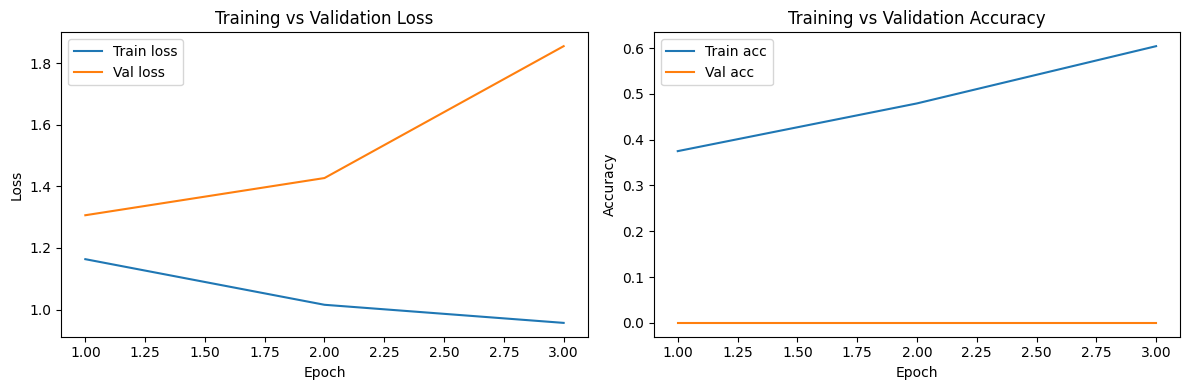

In [15]:
def plot_training_curves(history):
    history_dict = history.history

    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # 1. Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # 2. Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)
